**This dataset has 15 classes, there is other wit 39 and over 80000 images if wanted** [Plantdisease 39](https://data.mendeley.com/datasets/tywbtsjrjv/1)

**Import the libraries**

In [1]:
import torch, torchvision, matplotlib, os, pathlib, numpy, tqdm, sklearn.metrics
torch.cuda.is_available()

True

**Upload from the pc the kaggle file**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adrinsoriano","key":"6e5ae4bc5581019fcd226b8631d03602"}'}

**Move the file to the .kaggle folder and give permits**

This is needed because torchvision needs the dataset to be structured like this:

data/
└── PlantVillage/
    ├── Apple___Black_rot/
    │   ├── img1.jpg
    │   ├── img2.jpg
    │   └── ...
    ├── Apple___healthy/
    ├── Tomato___Late_blight/
    └── ...

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


**Donwload the dataset from kaggle as a zip**

In [4]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 97% 635M/658M [00:06<00:00, 195MB/s]
100% 658M/658M [00:06<00:00, 100MB/s]


**Unzip the dataset move the PlantVillage folder to data and remove the plantvillage folder, only one contains the dataset**

In [5]:
!unzip -q plantdisease.zip -d data/
!mv data/plantvillage/PlantVillage/ data/
!rm -r data/plantvillage

mv: cannot move 'data/plantvillage/PlantVillage/' to 'data/PlantVillage': Directory not empty


**If everything is fine this should return the data name**

In [6]:
print(os.listdir("data"))

['PlantVillage']


**Show the dataset classes**

In [7]:
print("\nContenido de data/PlantVillage:")
print(os.listdir("data/PlantVillage")[:5])


Contenido de data/PlantVillage:
['Tomato_Bacterial_spot', 'Potato___Late_blight', 'Tomato__Target_Spot', 'Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite']


**Normalize the dataset with transformations**

In [8]:
import torchvision.transforms, torchvision.datasets, torch.utils.data
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

#First create the transformation
transform = torchvision.transforms.Compose([
    v2.Resize((224,224)), #Resize the images
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), #Converts the image into a float32 tensor normalize between [0,1]
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) #Normalize the images from [0,1] to [-1,1], better when working with neural networks
])

"""
Apply the transformation to every image in the dataset

This can be done to single images with:
    img = transforms(img)

"""

dataset = ImageFolder(root='data/PlantVillage', transform=transform)




**Test to check that the transformations have been properly applied**

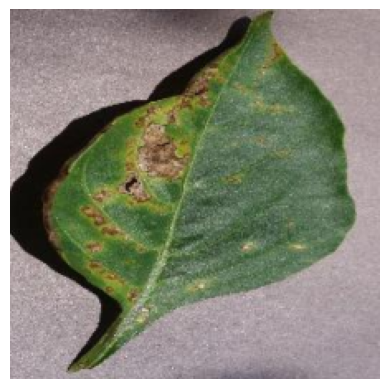

Etiqueta de la imagen: tensor([0])
Clases en el dataset: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Dimensiones de la imagen: torch.Size([3, 224, 224])


In [9]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

#Create a batch, the batch size indicates the number of images per batch
one_image_batchs = DataLoader(dataset, batch_size=1) #If we have 1000 images in the dataset now we have created 1000 batches

for img, label in one_image_batchs:  # Iterate on images and labels
    one_image = img[0]
    break #Only takes the first for this test


#Denormalization of the image to visualize, multiply to the values we applied in the transform
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
#(3,1,1) = (RGB, HEIGHT, WIDTH)
denormalized_img = one_image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

denormalized_img = denormalized_img.numpy().transpose(1, 2, 0)

plt.imshow(denormalized_img)
plt.axis('off')  # No axis
plt.show()

print(f"Etiqueta de la imagen: {label}") #The value returned corresponds to the position of the classes in the dataset.
print("Clases en el dataset:", dataset.classes)
print(f"Dimensiones de la imagen: {one_image.shape}") #(RGB, HEIGHT, WIDTH)


**Load a pre-trained model in order to obtain image information in our case Resnet18.**

In [10]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
resnetModel = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

#Freeze layers to take advantage of learned image viewing features
for param in resnetModel.parameters():
    param.requires_grad = False

#Change the last layer to adapt it to our dataset, this layer will have as many out_features as our dataset classes
#in_features = number of entries of the model
resnetModel.fc = nn.Linear(in_features = 512, out_features = 15)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


**Lose function and optimizer**

In [11]:
from torch import optim


#In the optimizer put the layers with the learning rate that we want for each one, in this case we only want the output layer (fc).
adam = optim.Adam(resnetModel.fc.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss()

**create the train_dataset and the test_dataset**

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

#Create the train dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# División aleatoria
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

from torch.utils.data import DataLoader

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


**Create the training cycle**

In [ ]:
from torch.utils.data import DataLoader

for epoch in range(5): #iterate the dataset x times
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    adam.zero_grad()
    outputs = resnetModel(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    adam.step()
    running_loss += loss.item()
    if i % 10 == 9:    # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
        running_loss = 0.0

print('Finished Training')


[1,    10] loss: 2.891
[1,    20] loss: 2.712
[1,    30] loss: 2.617
[1,    40] loss: 2.612
[1,    50] loss: 2.543
[1,    60] loss: 2.423
[1,    70] loss: 2.427
[1,    80] loss: 2.343
[1,    90] loss: 2.362
[1,   100] loss: 2.269
[1,   110] loss: 2.310
[1,   120] loss: 2.334
[1,   130] loss: 2.206
[1,   140] loss: 2.146
[1,   150] loss: 2.139
[1,   160] loss: 2.188
[1,   170] loss: 2.158
[1,   180] loss: 2.050
[1,   190] loss: 1.981
[1,   200] loss: 2.015
[1,   210] loss: 1.929
[1,   220] loss: 1.966
[1,   230] loss: 1.916
[1,   240] loss: 1.894
[1,   250] loss: 1.899
[1,   260] loss: 1.849
[1,   270] loss: 1.870
[1,   280] loss: 1.815
[1,   290] loss: 1.759
[1,   300] loss: 1.840
[1,   310] loss: 1.711
[1,   320] loss: 1.669
[1,   330] loss: 1.686
[1,   340] loss: 1.690
[1,   350] loss: 1.700
[1,   360] loss: 1.620
[1,   370] loss: 1.666
[1,   380] loss: 1.651
[1,   390] loss: 1.612
[1,   400] loss: 1.645
[1,   410] loss: 1.497
[1,   420] loss: 1.631
[1,   430] loss: 1.670
[1,   440] 

**Save the model weights in drive**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Save model in drive
torch.save(resnetModel.state_dict(), '/content/drive/MyDrive/modelo_entrenado.pth')



Mounted at /content/drive


**Load the model if needed**

In [13]:
from google.colab import files

uploaded = files.upload()

resnetModel.load_state_dict(torch.load("modelo_entrenado.pth"))
resnetModel.eval()


Saving modelo_entrenado.pth to modelo_entrenado.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Use the test data to rate the performance**

In [14]:
correct = 0
total = 0
resnetModel.eval()

with torch.no_grad():
    for images, labels in testloader:
        outputs = resnetModel(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Precisión del modelo en el conjunto de test: {100 * correct / total:.2f}%")


Precisión del modelo en el conjunto de test: 88.32%


**Upload an image to verify if is it classified correctly**

In [15]:
from google.colab import files
uploaded = files.upload()


Saving image (2).JPG to image (2).JPG


**Get the image path and apply the same transformations than the dataset**

In [20]:
from PIL import Image
from torchvision import transforms

img_path = next(iter(uploaded))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)  # Batch = 1


**Classify the image and print the predicted class**

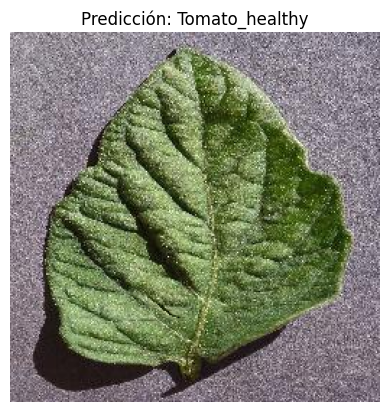

In [23]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

with torch.no_grad():
    outputs = resnetModel(input_tensor)
    _, predicted = torch.max(outputs, 1)


# Load the dataset classes
dataset = ImageFolder(root='data/PlantVillage')

plt.imshow(image)
plt.axis('off')
plt.title(f"Predicción: {dataset.classes[predicted.item()]}")
plt.show()

